####**Importing libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
#!pip install pyramid-arima
#from pyramid.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Flatten, TimeDistributed, Conv1D, Dropout, MaxPooling1D, Conv2D, ConvLSTM2D, BatchNormalization, Bidirectional
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler, ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from sklearn.metrics import mean_squared_error
import tensorflow as tf
import glob
import os
#from google.colab import drive
#pip install pmdarima

import warnings
warnings.filterwarnings('ignore')

####**Importing data**

In [2]:
data = pd.read_csv('Final_data.csv')

In [3]:
data.head()

,Period,Nationality,Region,State,Sector,Enrolments,Commencements
0,01-Apr-02,Tonga,East Asia & Pacific,NSW,Higher Education,23,7
1,01-Apr-02,Croatia,Europe & Central Asia,ACT,Higher Education,1,0
2,01-Apr-02,United Arab Emirates,Middle East & North Africa,WA,Higher Education,1,0
3,01-Apr-02,Bulgaria,Europe & Central Asia,SA,Higher Education,5,2
4,01-Apr-02,Uganda,Sub-Saharan Africa,ACT,Higher Education,3,1


####**Exploratory Data Analysis**

Text(0, 0.5, 'Region')

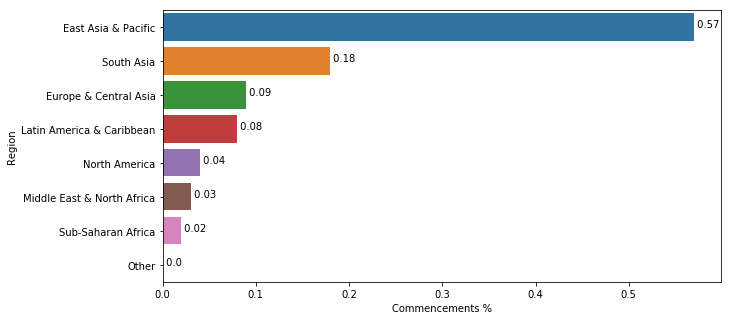

In [4]:
#Creating Region wise data
regions = data[['Commencements','Region']].groupby(['Region'], sort = True).sum('Commencements')
regions = regions.sort_values(by='Commencements',axis=0,ascending=False)
regions['Percentage'] = round((regions['Commencements']/sum(regions['Commencements'])),2)

#Plotting Region wise Commencements
plt.figure(figsize = (10,5))
splot=sns.barplot(y= regions.index,x=regions['Percentage'],orient = 'h',data=regions)
for i, v in enumerate(regions['Percentage']):
    plt.text(v, i," "+str(v), color='black')
plt.xlabel("Commencements %")
plt.ylabel("Region")

Text(0, 0.5, 'States')

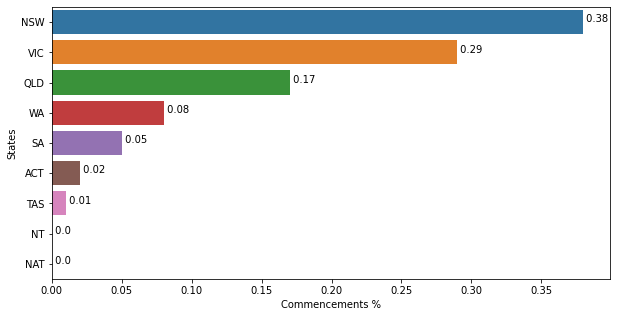

In [ ]:
#Creating State wise data
states = data[['Commencements','State']].groupby(['State'], sort = True).sum('Commencements')
states = states.sort_values(by='Commencements',axis=0,ascending=False)
states['Percentage'] = round((states['Commencements']/sum(states['Commencements'])),2)

#Plotting State wise Commencements
plt.figure(figsize = (10,5))
splot=sns.barplot(y= states.index,x=states['Percentage'],orient = 'h',data=regions)
for i, v in enumerate(states['Percentage']):
    plt.text(v, i," "+str(v), color='black')
plt.xlabel("Commencements %")
plt.ylabel("States")

Text(0, 0.5, 'Sectors')

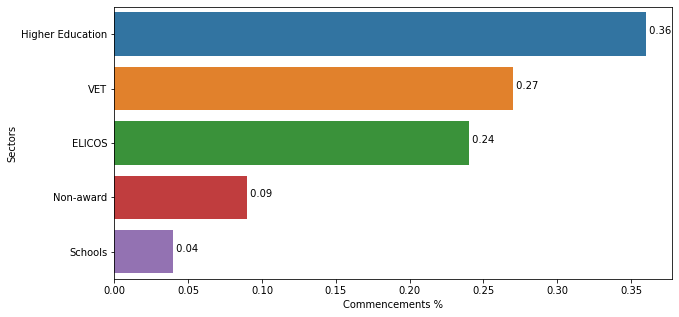

In [ ]:
#Creating Sector wise data
sectors = data[['Commencements','Sector']].groupby(['Sector'], sort = True).sum('Commencements')
sectors = sectors.sort_values(by='Commencements',axis=0,ascending=False)
sectors['Percentage'] = round((sectors['Commencements']/sum(sectors['Commencements'])),2)

#Plotting Sector wise Commencements
plt.figure(figsize = (10,5))
splot=sns.barplot(y= sectors.index,x=sectors['Percentage'],orient = 'h',data=regions)
for i, v in enumerate(sectors['Percentage']):
    plt.text(v, i," "+str(v), color='black')
plt.xlabel("Commencements %")
plt.ylabel("Sectors")

In [4]:
# Downsampling data to monthly by using sum metrics
period = data[['Commencements','Period']].groupby(['Period'], sort = True, as_index = False).sum('Commencements')
period['Period'] = pd.to_datetime(period['Period'])
period = period.sort_values(by='Period',axis=0)
period = period.set_index('Period')
period.head()

,Commencements
Period,
2002-01-01,12908
2002-02-01,45047
2002-03-01,73881
2002-04-01,82002
2002-05-01,86989


In [5]:
#Converting cumulative to absolute values
ts_data = period.copy()
ts_data['Diff'] = ts_data.diff(axis = 0, periods = 1)
ts_data = ts_data.fillna(value = 12908)  #Replacing null value with Jan 2002 value

#Function to copy original value for Jan for each year
for i in range(len(ts_data)):
    if ts_data['Diff'].iloc[i] < 0:
        ts_data['Diff'].iloc[i]=ts_data['Commencements'].iloc[i]
ts_data.head()

,Commencements,Diff
Period,,
2002-01-01,12908,12908.0
2002-02-01,45047,32139.0
2002-03-01,73881,28834.0
2002-04-01,82002,8121.0
2002-05-01,86989,4987.0


Text(0.5, 1.0, 'Commencements from 2002 to 2019')

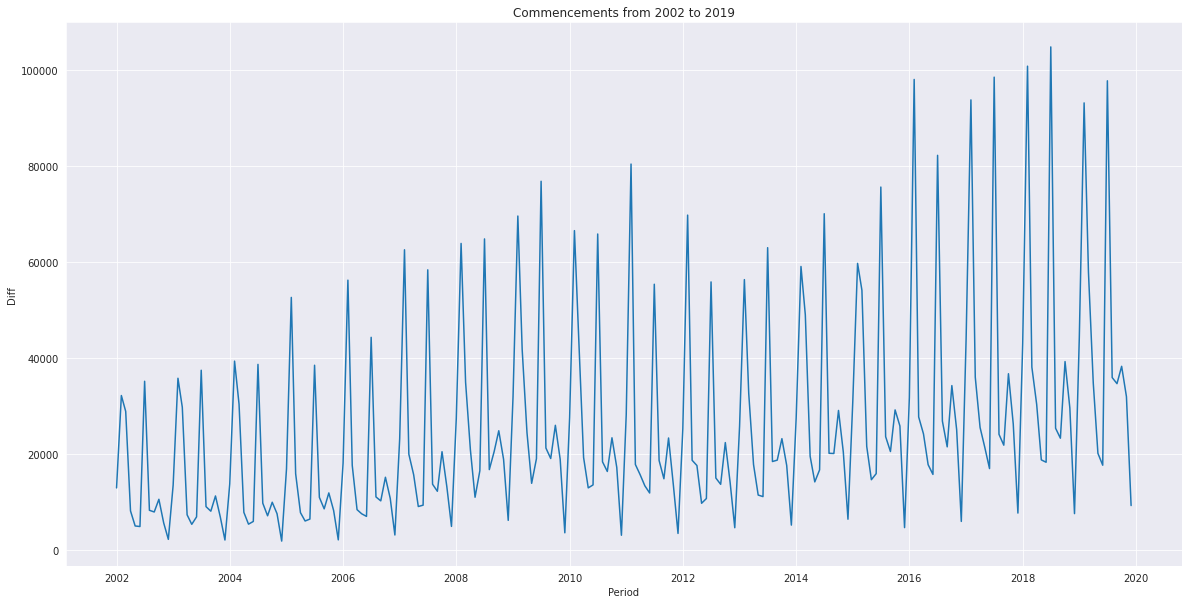

In [ ]:
#Plotting Commencements data
sns.set_style('darkgrid')
plt.figure(figsize = (20,10))
sns.lineplot(x = ts_data.index, y = 'Diff', data = ts_data)
plt.title('Commencements from 2002 to 2019')

**Observations:**

1) Trend is upwards

2) Seasonality is quarterly (on an average 2 cycles for 1 year) and its amplitude changes w.r.t. time (Multiplicative model instead of additive)

In [ ]:
#Descriptive statistics
round(ts_data['Diff'].describe(),2)

count       216.00
mean      26139.70
std       21870.55
min        1840.00
25%       11016.50
50%       19013.00
75%       32255.75
max      104708.00
Name: Diff, dtype: float64

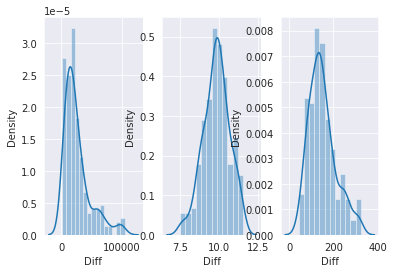

In [ ]:
fig, axs = plt.subplots(ncols=3)
sns.distplot(ts_data['Diff'], ax = axs[0])
sns.distplot(np.log(ts_data['Diff']), ax = axs[1])
sns.distplot(np.sqrt(ts_data['Diff']),ax = axs[2])
plt.show()

**ADF Test:**

**Null Hypothesis**: The series has a unit root (value of a =1) i.e. non-stationary

**Alternate Hypothesis**: The series has no unit root i.e. stationary

If we fail to reject the null hypothesis, we can say that the series is non-stationary i.e. if the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In [11]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller
def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [12]:
#apply adf test on original difference
adf_test(ts_data['Diff'])

Results of Dickey-Fuller Test:
Test Statistic                   0.095387
p-value                          0.965745
#Lags Used                      15.000000
Number of Observations Used    200.000000
Critical Value (1%)             -3.463476
Critical Value (5%)             -2.876102
Critical Value (10%)            -2.574532
dtype: float64


In [ ]:
#apply adf test on the log difference
adf_test(np.log(ts_data['Diff']))

Results of Dickey-Fuller Test:
Test Statistic                  -0.990127
p-value                          0.756848
#Lags Used                      15.000000
Number of Observations Used    200.000000
Critical Value (1%)             -3.463476
Critical Value (5%)             -2.876102
Critical Value (10%)            -2.574532
dtype: float64


In [ ]:
#apply adf test on the square root of difference
adf_test(np.sqrt(ts_data['Diff']))

Results of Dickey-Fuller Test:
Test Statistic                  -0.513109
p-value                          0.889433
#Lags Used                      15.000000
Number of Observations Used    200.000000
Critical Value (1%)             -3.463476
Critical Value (5%)             -2.876102
Critical Value (10%)            -2.574532
dtype: float64


**Log and square root transformation does not provide stationarity. Thus, differencing is used to make data stationary.**

####**Timeseries modelling**

#####**Pre-processing for SARIMA**

Text(0.5, 1.0, 'First order trend difference')

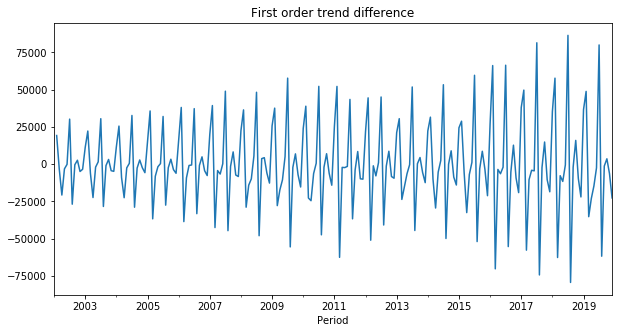

In [9]:
# Detrending original data with first order difference
ts_data['Trend_Diff_01'] = ts_data['Diff'].diff(periods = 1)

plt.figure(figsize=(10,5))
ts_data['Trend_Diff_01'].plot()
plt.title('First order trend difference')

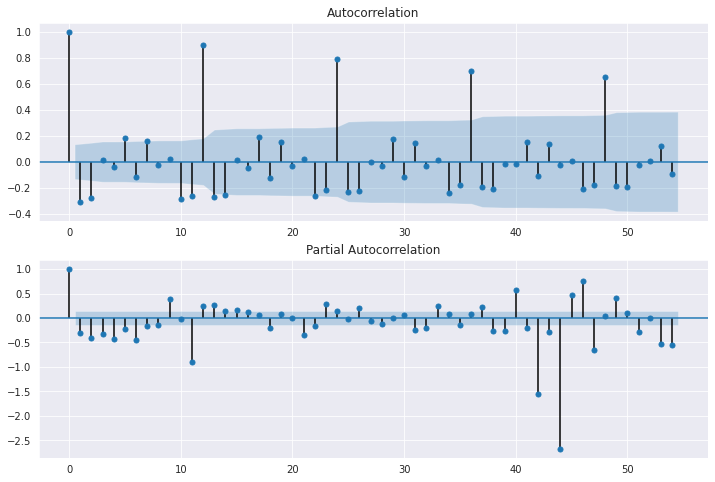

In [ ]:
#First order trend difference ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ts_data['Trend_Diff_01'].iloc[1:],lags=54,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(ts_data['Trend_Diff_01'].iloc[1:],lags=54,ax=ax2)


In [ ]:
#apply adf test on the log difference
adf_test(ts_data['Trend_Diff_01'].iloc[1:])

Results of Dickey-Fuller Test:
Test Statistic                  -3.485571
p-value                          0.008365
#Lags Used                      15.000000
Number of Observations Used    199.000000
Critical Value (1%)             -3.463645
Critical Value (5%)             -2.876176
Critical Value (10%)            -2.574572
dtype: float64


**Observation:**

1) Origindal data is non-stationary as per ACF and ADF test

2) First order difference provides stationarity, but with seasonality.

3) Sesonality is visible in ACF. Significant negative correlation at lag 2 suggests non-seasonal MA component as 2.

4) PACF has significant negative correlation, thus AR term is not considered.

5) Thus, p=0, d=1, q=2

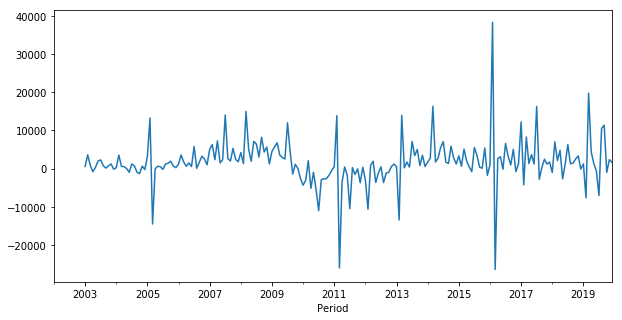

In [6]:
#Applying seasonal difference
ts_data['Seasonal_diff_01'] = ts_data['Diff'].diff(periods = 12)
ts_data['Seasonal_diff_01'].plot(figsize=(10,5))

In [ ]:
#apply adf test on the square root of difference
adf_test(ts_data['Seasonal_diff_01'].iloc[12:])

Results of Dickey-Fuller Test:
Test Statistic                  -2.160404
p-value                          0.220929
#Lags Used                       7.000000
Number of Observations Used    196.000000
Critical Value (1%)             -3.464161
Critical Value (5%)             -2.876402
Critical Value (10%)            -2.574692
dtype: float64


**As seasonal difference is still not stationary, first order difference of seasonal difference is taken.**

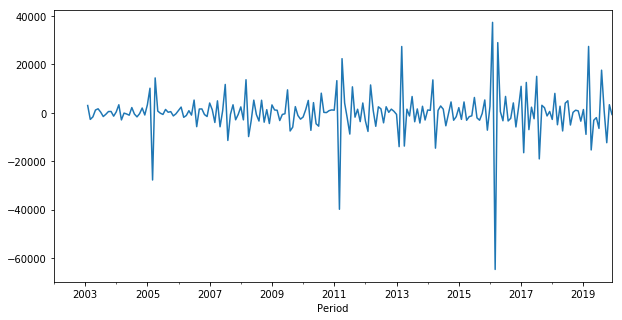

In [7]:
ts_data['First_Seasonal_Diff'] = ts_data['Seasonal_diff_01'].iloc[12:].diff(periods = 1)
ts_data['First_Seasonal_Diff'].plot(figsize=(10,5))

In [ ]:
#apply adf test on the square root of difference
adf_test(ts_data['First_Seasonal_Diff'].iloc[13:])

Results of Dickey-Fuller Test:
Test Statistic                -9.936485e+00
p-value                        2.735035e-17
#Lags Used                     6.000000e+00
Number of Observations Used    1.960000e+02
Critical Value (1%)           -3.464161e+00
Critical Value (5%)           -2.876402e+00
Critical Value (10%)          -2.574692e+00
dtype: float64


**Seasonal difference with 1st order difference resulted in stationary data.**

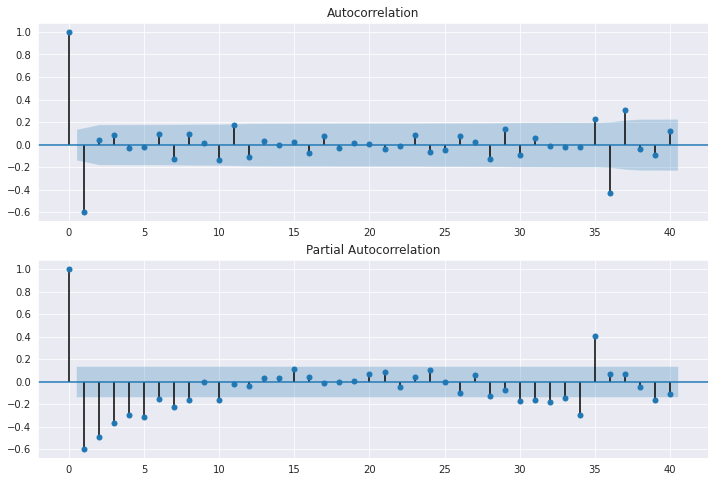

In [ ]:
#ACF and PACF of original data with lags = 0.25*n where n = 216
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(ts_data['First_Seasonal_Diff'].iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(ts_data['First_Seasonal_Diff'].iloc[13:],lags=40,ax=ax2)

**Observations:**

1) Effect of seasonality has been reduced. ACF - Cut's off at lag 1. Seasonal MA is 1

2) PACF has significant negative correlations, thus AR term is zero

Thus, P = 0; D = 2, Q = 1

#####**Fitting SARIMA Model**

In [ ]:
%%time

stepwise_model = auto_arima(ts_data['Diff'].iloc[0:192], start_p=0, start_q=0,
                           max_p=10, max_q=5, m=12,
                           start_P=0, start_Q = 0,
                           max_P = 10,max_Q = 5, max_D = 2,
                           d=1, D=2, seasonal=True, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)

print(stepwise_model.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 2, 0, 12); AIC=3659.168, BIC=3665.404, Fit time=0.063 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 2, 0, 12); AIC=3542.785, BIC=3555.257, Fit time=0.776 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=3416.243, BIC=3428.715, Fit time=5.139 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 2, 1, 12); AIC=3418.165, BIC=3433.755, Fit time=5.765 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 0, 12); AIC=3501.758, BIC=3511.112, Fit time=0.866 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 2, 2, 12); AIC=3424.348, BIC=3439.938, Fit time=10.140 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 2, 2, 12); AIC=3420.932, BIC=3439.640, Fit time=11.462 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 2, 1, 12); AIC=3400.494, BIC=3416.084, Fit time=5.776 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 2, 1, 12); AIC=3482.188, BIC=3494.660, Fit time=3.215 seconds
Fit ARIMA: order=(1, 1, 2)

In [8]:
#Creating training (2002 - 2017) and test (2018-2019) dataset
train = pd.DataFrame(ts_data['Diff'].iloc[0:192])
test = pd.DataFrame(ts_data['Diff'].iloc[192:216])

In [25]:
model=sm.tsa.statespace.SARIMAX(train['Diff'],order=(0, 1, 2),seasonal_order=(0,2,1,12))
results=model.fit()

In [26]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                 Diff   No. Observations:                  192
Model:             SARIMAX(0, 1, 2)x(0, 2, [1], 12)   Log Likelihood               -1690.103
Date:                              Sun, 02 May 2021   AIC                           3388.206
Time:                                      10:50:38   BIC                           3400.678
Sample:                                  01-01-2002   HQIC                          3393.268
                                       - 12-01-2017                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.3372      0.039    -33.947      0.000      -1.414      -1.260
ma.L2          0.4687      0.047      9.878      0.000       0.376       0.562
ma.S.L12      -0.9925      0.051    -19.287      0.000      -1.093      -0.892
sigma2      3.177e+07   1.55e-09   2.05e+16      0.000    3.18e+07    3.18e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.37   Jarque-Bera (JB):               370.38
Prob(Q):                              0.54   Prob(JB):                         0.00
Heteroskedasticity (H):               2.47   Skew:                             0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.56e+31. Standard errors may be unstable.
"""

In [27]:
#MSE
train_mse = mean_squared_error(ts_data['Diff'].iloc[1:192], results.fittedvalues[1:])
round(train_mse,2)

56414836.0

In [37]:
# Predicting
predict = round(results.predict(start=192,end=215,dynamic=True),0)
predict

2018-01-01     47741.0
2018-02-01     99805.0
2018-03-01     38661.0
2018-04-01     27602.0
2018-05-01     23308.0
2018-06-01     18584.0
2018-07-01    104866.0
2018-08-01     26178.0
2018-09-01     23816.0
2018-10-01     39579.0
2018-11-01     28445.0
2018-12-01      8954.0
2019-01-01     51150.0
2019-02-01    106022.0
2019-03-01     41450.0
2019-04-01     29799.0
2019-05-01     25296.0
2019-06-01     20325.0
2019-07-01    111411.0
2019-08-01     28381.0
2019-09-01     25916.0
2019-10-01     42573.0
2019-11-01     30773.0
2019-12-01     10327.0
Freq: MS, Name: predicted_mean, dtype: float64

In [38]:
test_mse = mean_squared_error(ts_data['Diff'].iloc[192:216], predict)
round(test_mse,2)

39236343.46

Text(0.5, 1.0, 'Actual  vs Fitted Values')

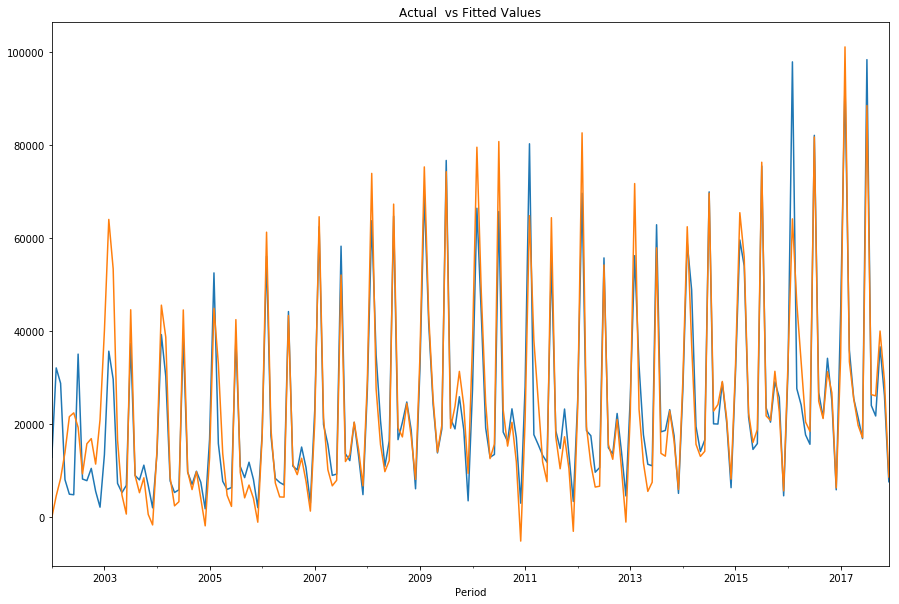

In [30]:
# Fitted values  vs original train data
plt.figure(figsize=(15,10))
ts_data['Diff'].iloc[0:192].plot()
results.fittedvalues[0:].plot()
plt.title('Actual  vs Fitted Values')

Text(0.5, 1.0, 'SARIMA: Predicted Test vs Actual Test')

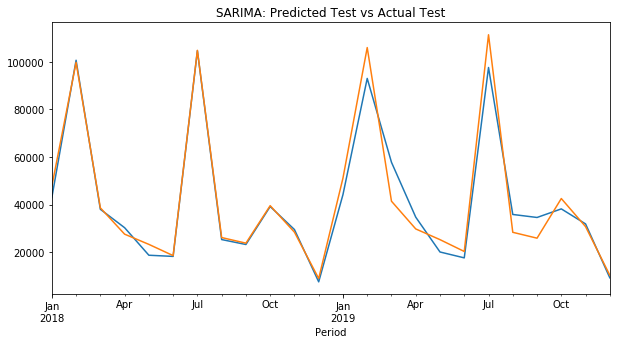

In [39]:
# Test data accuracy vs original test data
plt.figure(figsize=(10,5))
ts_data['Diff'].iloc[192:216].plot()
predict.plot()
plt.title('SARIMA: Predicted Test vs Actual Test')

In [46]:
test_df = pd.DataFrame(round(predict,0))
test_df

,predicted_mean
2018-01-01,47741.0
2018-02-01,99805.0
2018-03-01,38661.0
2018-04-01,27602.0
2018-05-01,23308.0
2018-06-01,18584.0
2018-07-01,104866.0
2018-08-01,26178.0
2018-09-01,23816.0
2018-10-01,39579.0


In [47]:
train_df = pd.DataFrame(round(results.fittedvalues,0),columns = ['fitted_values'])
train_df

,fitted_values
Period,
2002-01-01,0.0
2002-02-01,4611.0
2002-03-01,8364.0
2002-04-01,13980.0
2002-05-01,21651.0
...,...
2017-08-01,26396.0
2017-09-01,26133.0
2017-10-01,40068.0


In [49]:
#Forecasting 3 years (36 months out of sample)
forecast = pd.DataFrame(round(results.predict(start=216,end=251,dynamic=True),0))
forecast

,predicted_mean
2020-01-01,54650.0
2020-02-01,112332.0
2020-03-01,44330.0
2020-04-01,32088.0
2020-05-01,27376.0
2020-06-01,22157.0
2020-07-01,118047.0
2020-08-01,30675.0
2020-09-01,28109.0
2020-10-01,45658.0


#####**Model check/diagnosis**

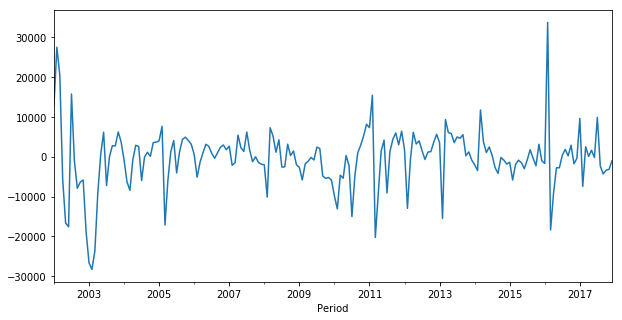

In [50]:
#Residual plot
results.resid.plot(figsize=(10,5))

In [51]:
results.resid

Period
2002-01-01    12908.000000
2002-02-01    27528.084499
2002-03-01    20470.302270
2002-04-01    -5858.676786
2002-05-01   -16664.018345
                  ...     
2017-08-01    -2329.130263
2017-09-01    -4327.291081
2017-10-01    -3391.160807
2017-11-01    -3165.763985
2017-12-01    -1034.756869
Length: 192, dtype: float64

**Observation**

1) Residual has approximately constant mean at zero, with varied variance till 2003 and for 2016.

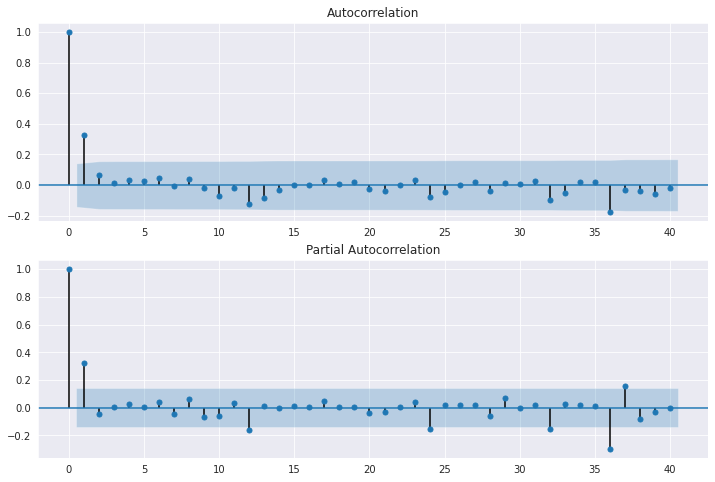

In [ ]:
#ACF and PACF of original data with lags = 0.25*n where n = 216
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results.resid,lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(results.resid,lags=40,ax=ax2)

In [ ]:
#ADF test for residual
adf_test(results.resid)

Results of Dickey-Fuller Test:
Test Statistic                -9.908726e+00
p-value                        3.211310e-17
#Lags Used                     0.000000e+00
Number of Observations Used    1.910000e+02
Critical Value (1%)           -3.465059e+00
Critical Value (5%)           -2.876794e+00
Critical Value (10%)          -2.574901e+00
dtype: float64


**Observation**

1) Residual has positive ACF and PACF at lag 1

2) Residual is stationary as per ADF test

#####**Forecasting**

In [ ]:
#from google.colab import files
#ts_data.to_csv('data.csv')
#files.download('data.csv') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Text(0, 0.5, '# International students')

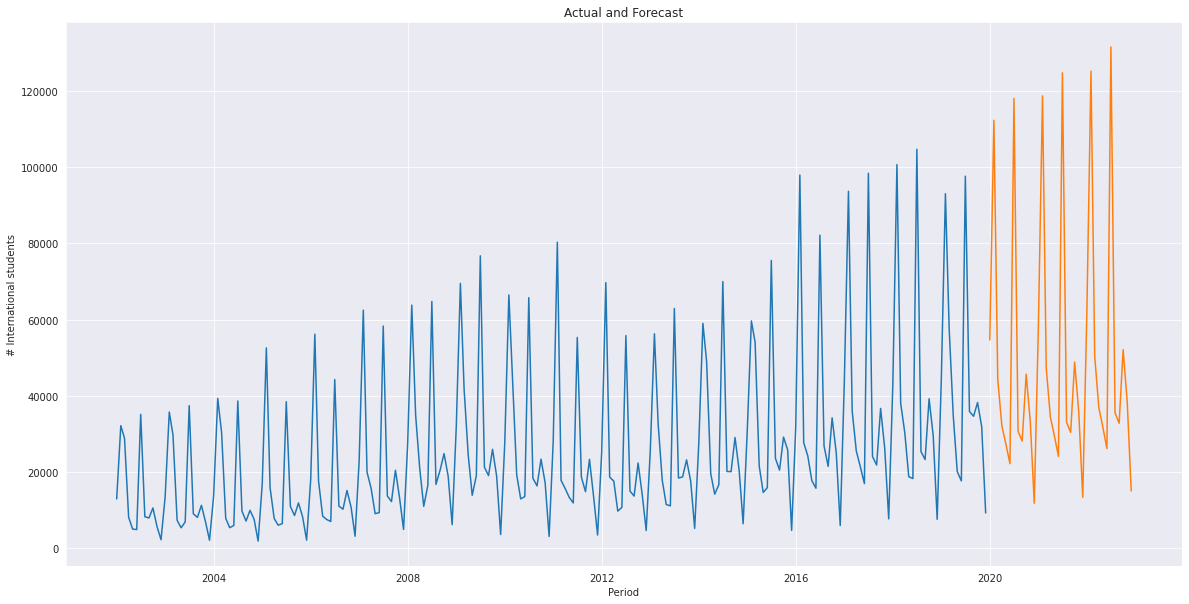

In [ ]:
# Plotting actual and forecasted data
prediction = pd.concat([ts_data['Diff'],forecast],axis=0)
prediction = pd.DataFrame(prediction)
prediction = prediction.rename(columns={0:"Actual"})

plt.figure(figsize=(20,10))
plt.plot(prediction)
plt.title('Actual and Forecast')
plt.xlabel('Period')
plt.ylabel('# International students')

####**LSTM**

#####**Pre-processing**

In [9]:
lstm_train = train.copy().values
lstm_test = test.copy().values
print('Shape of: Train {}, Test {}'.format(lstm_train.shape, lstm_test.shape))

Shape of: Train (192, 1), Test (24, 1)


In [10]:
# preparing independent and dependent features (Source: https://github.com/krishnaik06)
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [11]:
n_steps = 12
# split into samples
train_X, train_Y = prepare_data(lstm_train, n_steps)
test_X, test_Y = prepare_data(lstm_test, n_steps)
print('Shape of: Train data {}; Train labels {}; Test data {}; Test labels {}'.format(train_X.shape, train_Y.shape, test_X.shape, test_Y.shape))

Shape of: Train data (180, 12, 1); Train labels (180, 1); Test data (12, 12, 1); Test labels (12, 1)


#####**Model building**

In [12]:
def step_decay(epoch):
   initial_lrate = 0.001
   drop = 0.5
   epochs_drop = 5.0
   lrate = initial_lrate*tf.math.pow(drop,  
           tf.math.floor((1+epoch)/epochs_drop))
   return float(lrate)

lr_decay = LearningRateScheduler(step_decay)


lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=np.sqrt(0.1),
    patience=5,
    verbose=1,
    mode='auto',
    min_delta=0.0001,
    cooldown=0,
    min_lr=0.5e-6)


callback = [lr_reducer, lr_decay]

In [15]:
# define model
def lstm_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(500, activation='relu', return_sequences=True, input_shape=(n_steps, 1)))
    lstm_model.add(LSTM(500, activation='relu'))
    lstm_model.add(Dense(1))
    return lstm_model

lstm_model = lstm_model()
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 12, 500)           1004000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 500)               2002000   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 501       
Total params: 3,006,501
Trainable params: 3,006,501
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#lstm_model = lstm_model()
lstm_model.compile(loss='mse', optimizer=optimizers.Adam(learning_rate=0.01), metrics=('mse'))

# fit model

history = lstm_model.fit(train_X, train_Y, validation_split=0.3, epochs=100, 
                              batch_size=10,shuffle=False)

Epoch 1/100
13/13 [==============================] - 11s 589ms/step - loss: 13731637677.7143 - mse: 13731637677.7143 - val_loss: 1115646976.0000 - val_mse: 1115646976.0000
Epoch 2/100
12/13 [==========================>...] - ETA: 0s - loss: 612431712.0000 - mse: 612431712.0000

In [ ]:
ylim = max(max(lstm_model.history.history['val_loss']), max(lstm_model.history.history['loss']))
ylim

11041721344.0

(0.0, 11041721344.0)

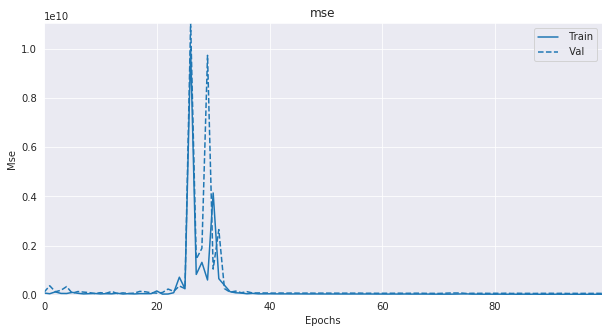

In [ ]:
#Plotting accuracy
plt.figure(figsize=(10, 5))
plotter_loss = tfdocs.plots.HistoryPlotter()
plotter_loss.plot({"": history}, metric = "mse")
plt.title("mse")
plt.ylim([0,ylim])

**train_Y = 2003 to 2017; test_Y = 2019 as train_X starts from 2002 and test_X is 2018.**

In [55]:
train_Y_df = pd.DataFrame(train_Y, index = train_df.index[12:192], columns=['train']) 
test_Y_df = pd.DataFrame(test_Y, index = test_df.index[12:], columns=['test'])

In [79]:
#Predicting test dataset
lstm_model_test = lstm_model.predict(test_X)
lstm_model_test = pd.DataFrame(lstm_model_test,index=test_Y_df.index, columns=['test'])
test_mse = mean_squared_error(test_Y_df, lstm_model_test)
print('MSE:{}',format(round(test_mse,2)))
print(lstm_model_test)

MSE:{} 66456329.11
                    test
2019-01-01  42612.878906
2019-02-01  93416.289062
2019-03-01  40311.093750
2019-04-01  32199.371094
2019-05-01   9344.019531
2019-06-01  13467.313477
2019-07-01  95364.492188
2019-08-01  24146.605469
2019-09-01  21125.644531
2019-10-01  37856.835938
2019-11-01  27058.060547
2019-12-01   9845.964844


Text(0.5, 1.0, 'LSTM: Predicted Test vs Actual Test')

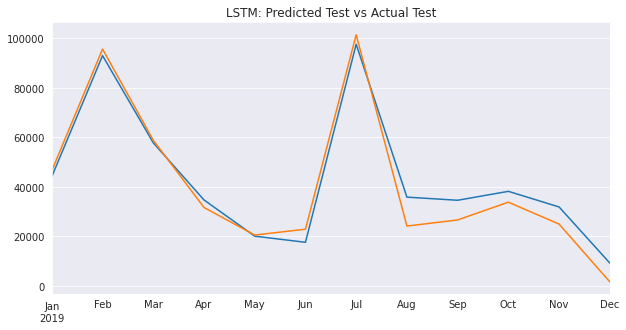

In [ ]:
# Test data accuracy vs original test data
plt.figure(figsize=(10,5))
test_Y_df['test'].plot()
lstm_model_test['test'].plot()
plt.title('LSTM: Predicted Test vs Actual Test')

In [ ]:
#Mounting google drive
#drive.mount('/content/drive')
#Saving model to google drive
#lstm_model.save('/content/drive/My Drive')

INFO:tensorflow:Assets written to: /content/drive/My Drive/assets


In [88]:
temp_input

[9334.446,
 41827.707,
 78498.695,
 50828.42,
 31855.96,
 8530.969,
 14624.832,
 76836.24,
 32920.152,
 29237.047,
 35217.43,
 25691.074,
 8604.133]

#####**Predicting for next 3 years**

In [90]:
x_input = np.array([44213, 93054, 57809, 34744, 20109, 17635, 97654, 35879, 34615, 38223, 31908, 9239])
temp_input=list(x_input)
temp_input

[44213,
 93054,
 57809,
 34744,
 20109,
 17635,
 97654,
 35879,
 34615,
 38223,
 31908,
 9239]

In [91]:
x_input=np.array(temp_input[1:])
x_input

array([93054, 57809, 34744, 20109, 17635, 97654, 35879, 34615, 38223,
       31908,  9239])

In [95]:
x_input = x_input.reshape((1, 12, 1))
x_input

array([[[ 9334.446],
        [41827.707],
        [78498.695],
        [50828.42 ],
        [31855.96 ],
        [ 8530.969],
        [14624.832],
        [76836.24 ],
        [32920.152],
        [29237.047],
        [35217.43 ],
        [25691.074]]], dtype=float32)

In [96]:
yhat = lstm_model.predict(x_input, verbose=0)
yhat

array([[8604.133]], dtype=float32)

In [97]:
# demonstrate prediction for next 10 days (https://github.com/krishnaik06)

#2019 data
x_input = np.array([44213, 93054, 57809, 34744, 20109, 17635, 97654, 35879, 34615, 38223, 31908, 9239])
temp_input=list(x_input)
lst_output=[]
i=0
while(i<36):
    
    if(len(temp_input)>12):
        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        #print(x_input)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = lstm_model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.append(yhat[0][0])
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.append(yhat[0][0])
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps, 1))
        yhat = lstm_model.predict(x_input, verbose=0)
        #print(yhat[0])
        temp_input.append(yhat[0][0])
        lst_output.append(yhat[0][0])
        i=i+1
    

#print(lst_output)
lst_output_df = pd.DataFrame(lst_output, index = forecast.index, columns=['predict'])

In [98]:
lst_output_df

,predict
2020-01-01,43044.488281
2020-02-01,88091.523438
2020-03-01,55302.156250
2020-04-01,34566.113281
2020-05-01,8648.432617
2020-06-01,11887.898438
2020-07-01,89946.703125
2020-08-01,35027.332031
2020-09-01,32622.560547
2020-10-01,37344.160156


Text(0, 0.5, '# International students')

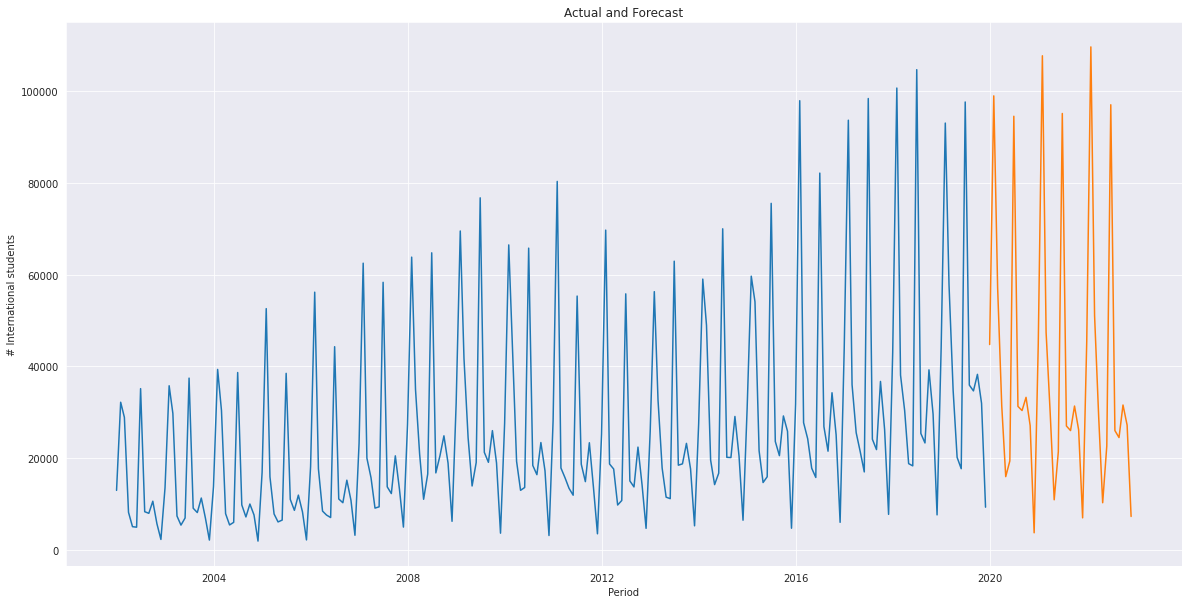

In [ ]:
# Plotting actual and forecasted data
prediction_lstm = pd.concat([ts_data['Diff'],lst_output_df],axis=0)
prediction_lstm = pd.DataFrame(prediction_lstm)
prediction_lstm = prediction_lstm.rename(columns={0:"Actual"})

plt.figure(figsize=(20,10))
plt.plot(prediction_lstm)
plt.title('Actual and Forecast')
plt.xlabel('Period')
plt.ylabel('# International students')

####**Yearly consolidation**

In [ ]:
SARIMA_pred = pd.DataFrame(forecast.resample('Y').sum())
lstm_pred = pd.DataFrame(lst_output_df.resample('Y').sum())
lstm_pred

,predict
2020-12-31,487543.232178
2021-12-31,474257.552246
2022-12-31,481185.181152


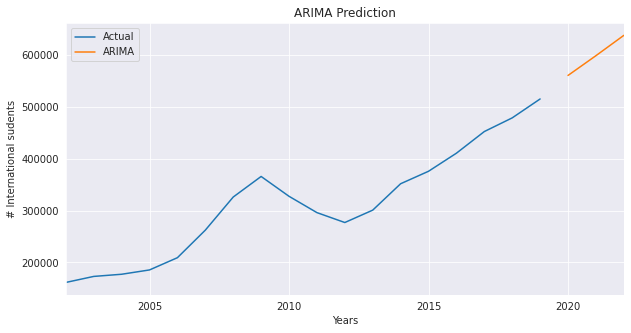

In [ ]:
yearly_SARIMA = pd.DataFrame(ts_data['Diff'].resample('Y').sum())
yearly_SARIMA = pd.concat([yearly_SARIMA,SARIMA_pred])
yearly_SARIMA = yearly_SARIMA.rename(columns={"Diff": "Actual", "forecast": "ARIMA"})
yearly_SARIMA.plot(figsize = (10,5))
plt.title('ARIMA Prediction')
plt.xlabel('Years')
plt.ylabel('# International sudents')
plt.show()
plt.show()

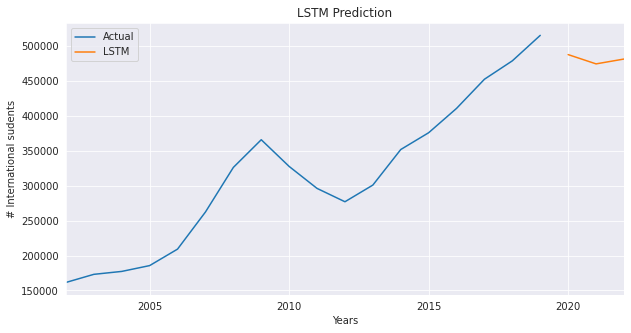

In [ ]:

yearly_LSTM = pd.DataFrame(ts_data['Diff'].resample('Y').sum())
yearly_LSTM = pd.concat([yearly_LSTM,lstm_pred])
yearly_LSTM = yearly_LSTM.rename(columns={"Diff": "Actual", "predict": "LSTM"})
yearly_LSTM.plot(figsize = (10,5))
plt.title('LSTM Prediction')
plt.xlabel('Years')
plt.ylabel('# International sudents')
plt.show()

#####**Conclusion**

Although, both the models provided better results, but SARIMA has performed marginally better than LSTM model. But due to black-swan event of COVID-19 is not accounted in this data. However, these predictions can be used to estimate financial loss by comparing actual commencements.